<a href="https://colab.research.google.com/github/Rendy3001/BDS/blob/main/OpinionLeaderDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Opinion leader detection network
The purpose is to identify central figures or organizations, especially those consistently associated with high sentiment, indicating influence and or potentially trustworthiness.

By analyzing the frequency and sentiment of mentions for key entities, opinion leaders, we will construct a network where central nodes will represent opinion leaders in the AI field.

---



In [1]:
#Installing required packages
!pip install ollama pandas networkx matplotlib tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00


In [2]:
#Installing Ollama
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids
The following NEW packages will be installed:
  libpci3 pci.ids pciutils
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,581 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 343 kB in 1s (283 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initializ

In [3]:
import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [4]:
!ollama pull qwen2.5

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling 2bada8a74506...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   0% ▕▏    0 B/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   0% ▕▏ 2.8 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   1% ▕▏  26 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   1% ▕▏  56 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   2% ▕▏  71 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   2% ▕▏  95 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   2% ▕▏ 104 MB/4.7 GB                  pulling manifest 
pulling 2bada8a74506...   3% ▕▏ 126 MB/4.7 GB             

#Defining an extraction schema, where the relationships will include:



*   "from": "Entity Name"
*   "to": "Article Title"
*   "type": "mention"
*   "sentiment": "sentiment_score"

In [45]:
#Importing necessary components
import json
import ollama
import networkx as nx
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


In [46]:
#Formulating extraction prompt
SYSTEM_PROMPT = """Extract relationships between companies or thought leaders and the articles they are mentioned in. Focus on capturing the sentiment associated with each mention and the frequency of mentions across the articles. Provide the output in this JSON format:
{
 "edges": [
   {"from": "Entity Name", "to": "Article Title", "type": "mention", "sentiment": "sentiment_score"}
 ]
}
The "type" field should always be "mention".

The "sentiment" field should represent the sentiment score of the article where the entity is mentioned, which can range from -1 (negative sentiment) to 1 (positive sentiment).

Ensure that the output is a valid JSON object with an 'edges' array, even if it is empty. The output must be in English.

Examples based on the input articles:
1. {"from": "Google", "to": "New AI Feature Summarizes Google Meet Conversations", "type": "mention", "sentiment": 0.3}
2. {"from": "TikTok", "to": "TikTok Lite Removes Reward Feature in EU", "type": "mention", "sentiment": 0.1}
3. {"from": "Apple", "to": "AI Gadgets: Setting Expectations", "type": "mention", "sentiment": -0.2}
4. {"from": "Adobe", "to": "AI Tools for Content Creation", "type": "mention", "sentiment": 0.5}
5. {"from": "Microsoft", "to": "AI Tools for Business Productivity", "type": "mention", "sentiment": 0.4}
"""


In [47]:
#Creating function for extracting relationships
def extract_relationships(article):
    prompt = f"""
    Extract key relationships between companies or thought leaders and the articles they are mentioned in from this text:
    Title: {article['title']}
    Text: {article['text']}

    Focus on capturing the sentiment associated with each mention and the frequency of mentions across the articles.
    Provide the output in the following JSON format:
    {{
     "edges": [
       {{"from": "Entity Name", "to": "Article Title", "type": "mention", "sentiment": "sentiment_score"}}
     ]
    }}

    The "type" field should always be "mention". The "sentiment" field should represent the sentiment score of the article where the entity is mentioned, ranging from -1 (negative sentiment) to 1 (positive sentiment).
    """

    response = ollama.chat(
        model='qwen2.5',
        messages=[
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': prompt},
        ],
        format='json',
        options={"temperature": 0.1}
    )

    return response['message']['content']

In [48]:
#Importing articles
!wget https://raw.githubusercontent.com/aaubs/ds-master/refs/heads/main/data/paraphrased_articles.jsonl

--2025-01-09 20:33:12--  https://raw.githubusercontent.com/aaubs/ds-master/refs/heads/main/data/paraphrased_articles.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2620931 (2.5M) [text/plain]
Saving to: ‘paraphrased_articles.jsonl.1’

paraphrased_article 100%[===================>]   2.50M  --.-KB/s    in 0.05s   

2025-01-09 20:33:13 (46.7 MB/s) - ‘paraphrased_articles.jsonl.1’ saved [2620931/2620931]



In [49]:
#Reading input articles
with open('paraphrased_articles.jsonl', 'r', encoding='utf-8') as f:
    articles = [json.loads(line) for line in f][:20]

#Processing articles
results = []
for article in tqdm(articles, desc="Processing articles"):
    try:
        extracted_data = json.loads(extract_relationships(article))
        results.append({
            'title': article['title'],
            'extracted_data': extracted_data
        })
    except json.JSONDecodeError as e:
        print(f"Error processing article '{article['title']}': {str(e)}")
    except Exception as e:
        print(f"Unexpected error processing article '{article['title']}': {str(e)}")

#Displaying first 5 results
for i, result in enumerate(results[:5]):
    print(f"Article {i+1}: {result['title']}")
    print(json.dumps(result['extracted_data'], indent=2))
    print("\n" + "="*20 + "\n")

#Saving all results
with open('opinion_leader_relationships.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

Processing articles:   0%|          | 0/20 [00:00<?, ?it/s]

Article 1: New AI Feature Summarizes Google Meet Conversations
{
  "edges": [
    {
      "from": "Google",
      "to": "New AI Feature Summarizes Google Meet Conversations",
      "type": "mention",
      "sentiment": 0.8
    }
  ]
}


Article 2: AI Gadgets: Setting Expectations
{
  "edges": [
    {
      "from": "Rabbit R1",
      "to": "AI Gadgets: Setting Expectations",
      "type": "mention",
      "sentiment": -0.5
    },
    {
      "from": "Humane AI Pin",
      "to": "AI Gadgets: Setting Expectations",
      "type": "mention",
      "sentiment": -0.5
    },
    {
      "from": "Google",
      "to": "AI Gadgets: Setting Expectations",
      "type": "mention",
      "sentiment": 0.2
    }
  ]
}


Article 3: TikTok Lite Removes Reward Feature in EU
{
  "edges": [
    {
      "from": "TikTok",
      "to": "TikTok Lite Removes Reward Feature in EU",
      "type": "mention",
      "sentiment": 0.1
    }
  ]
}


Article 4: US Investigates Chinese Connected Cars; Alibaba Cloud Cuts P

In [50]:
#Creating graph
G = nx.Graph()

#Processing  results
for result in tqdm(results, desc="Processing Results"):
    for edge in result['extracted_data'].get('edges', []):
        entity = edge.get('from')
        article_title = edge.get('to')

        if entity and article_title:
            #Adding nodes to the graph with type attributes
            if not G.has_node(entity):
                G.add_node(entity, type='entity')
            if not G.has_node(article_title):
                G.add_node(article_title, type='article')

            #Adding edges between entity and article with sentiment and type
            G.add_edge(entity, article_title, sentiment=edge.get('sentiment', 0), type=edge.get('type', ''))

Processing Results:   0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
#Creating function to calculate centralities
def calculate_centralities(graph):
    return {
        'degree': nx.degree_centrality(graph),
        'betweenness': nx.betweenness_centrality(graph),
        'eigenvector': nx.eigenvector_centrality(graph, max_iter=1000)
    }

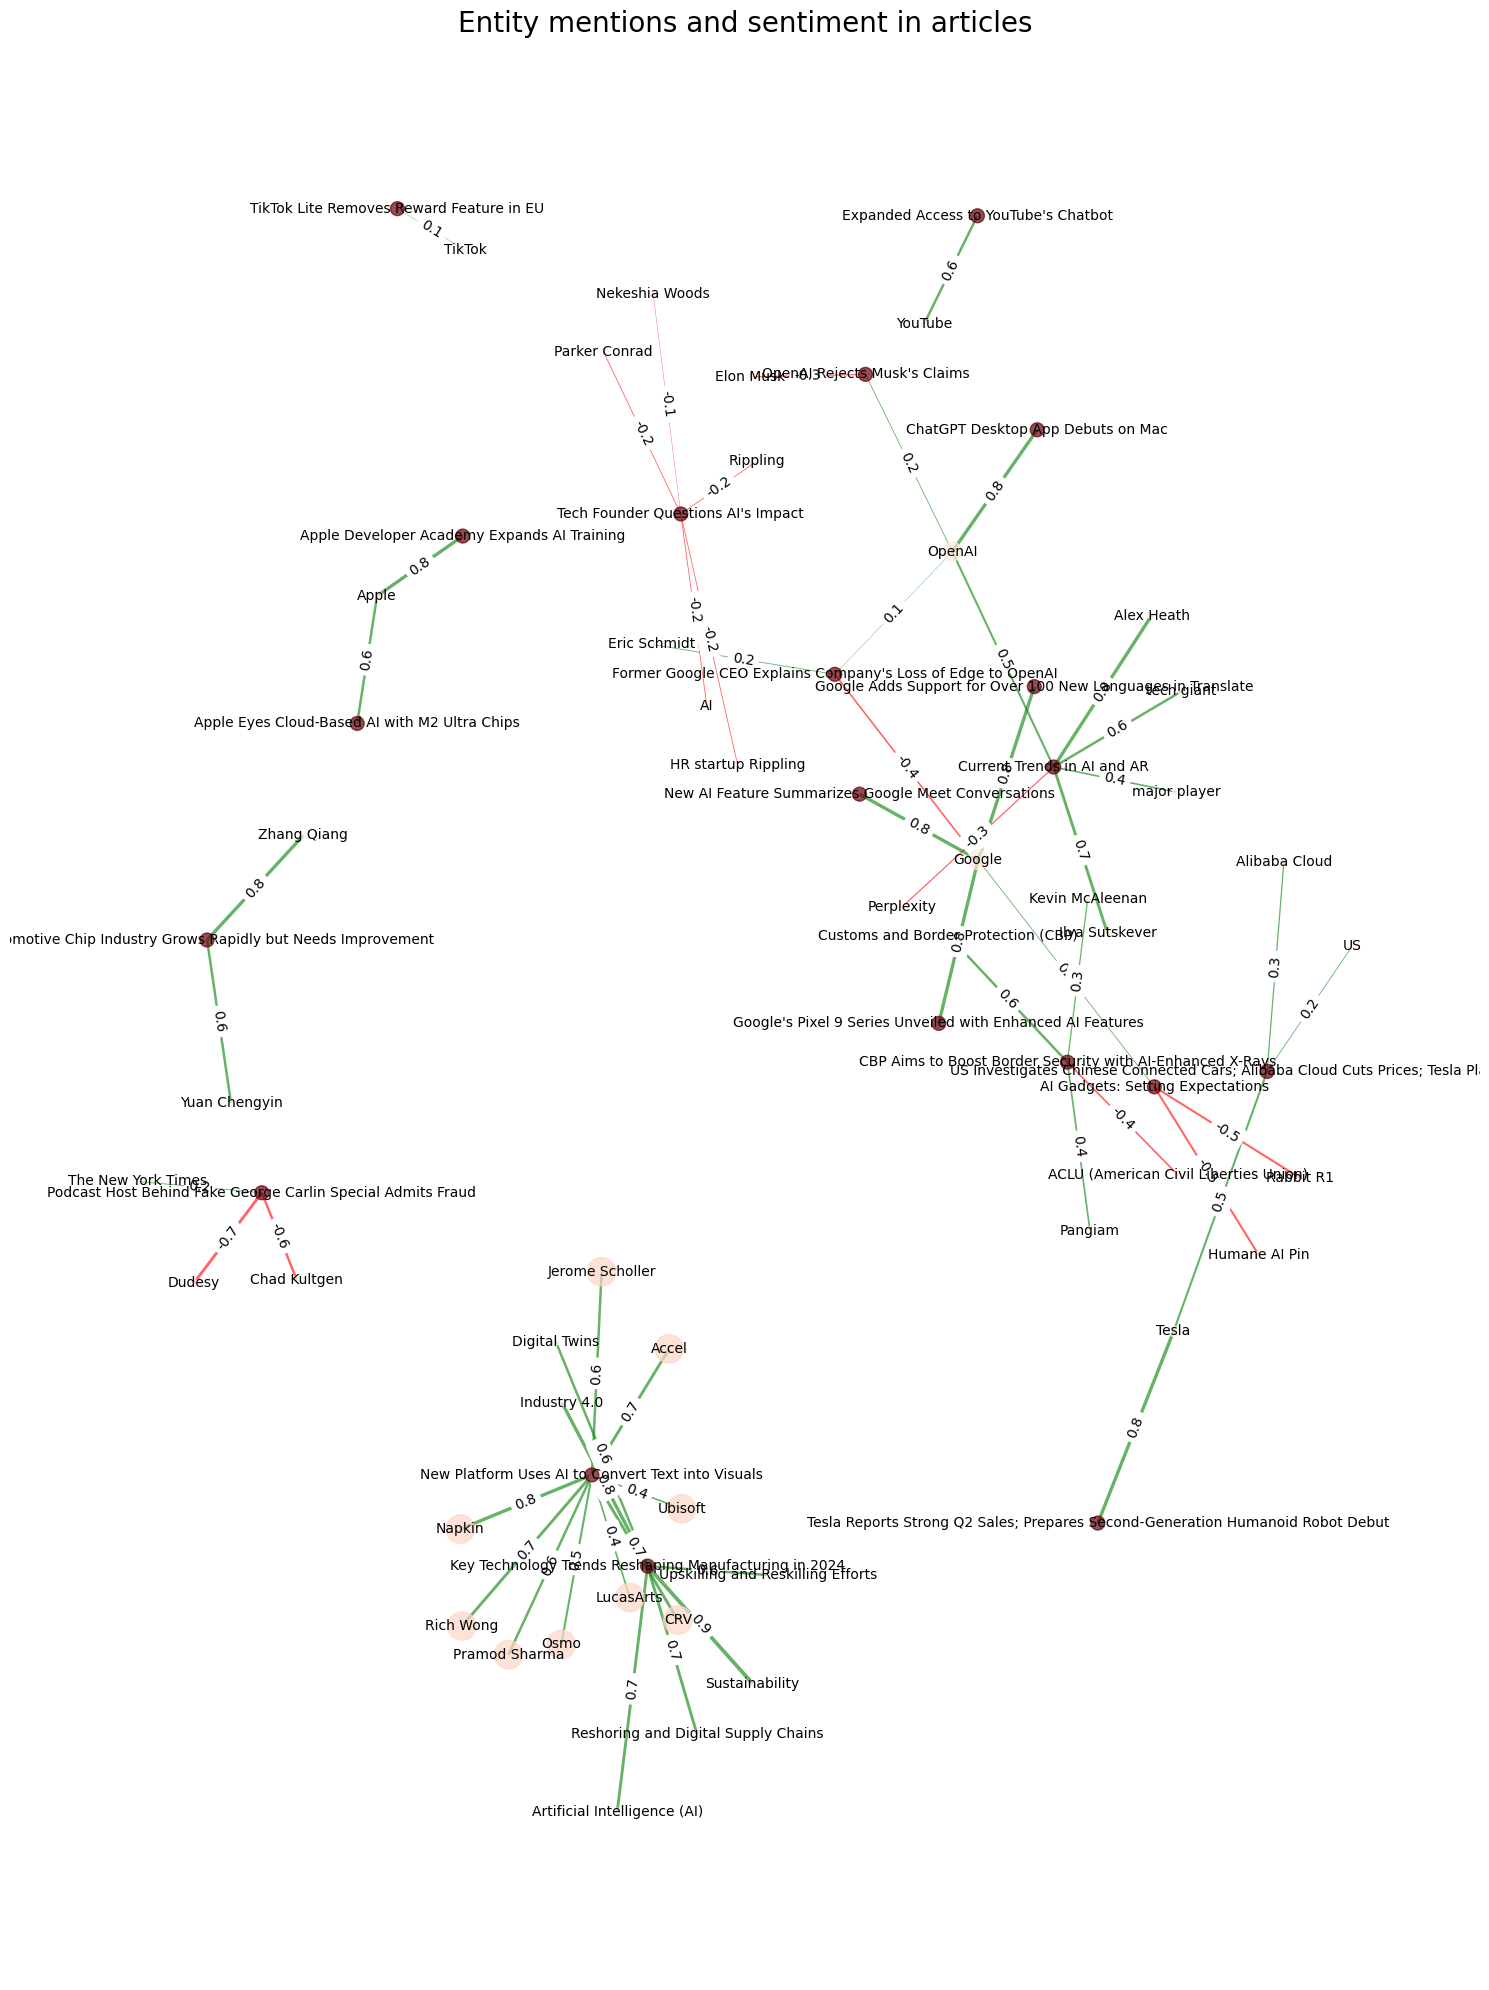

In [56]:
#Calculating all centralities
centralities = calculate_centralities(G)

#Normalizing centrality values for node size scaling
min_degree_centrality = min(centralities['degree'].values())
max_degree_centrality = max(centralities['degree'].values())
min_betweenness_centrality = min(centralities['betweenness'].values())
max_betweenness_centrality = max(centralities['betweenness'].values())
min_eigenvector_centrality = min(centralities['eigenvector'].values())
max_eigenvector_centrality = max(centralities['eigenvector'].values())

#Initializing node sizes and colors
sizes = []
node_colors = []

#Assigning node sizes and colors based on centrality values
for node in G.nodes(data=True):
    node_id = node[0]
    node_data = node[1]

    if node_data.get('type') == 'entity':
        degree_centrality = centralities['degree'].get(node_id, 0)
        betweenness_centrality = centralities['betweenness'].get(node_id, 0)
        eigenvector_centrality = centralities['eigenvector'].get(node_id, 0)

        #Calculating weighted average of centralities
        centrality_value = (degree_centrality + betweenness_centrality + eigenvector_centrality) / 3

        #Scaling node size and color by centrality
        sizes.append(centrality_value * 5000)
        node_colors.append(centrality_value)
    else:
        sizes.append(100)
        node_colors.append(0.5)

#Preparing the layout for the entire graph
plt.figure(figsize=(15, 20))
pos = nx.spring_layout(G, k=0.15, iterations=20)

#Drawing the nodes with size based on centrality and color based on centrality
nx.draw_networkx_nodes(
    G, pos, node_size=sizes, alpha=0.7, node_color=node_colors, cmap=plt.cm.Reds
)

#Setting edge widths and colors based on sentiment
edge_colors = []
edge_widths = []
for u, v, data in G.edges(data=True):
    sentiment = data.get('sentiment', 0.1)
    edge_widths.append(abs(sentiment) * 3 if sentiment else 1)
    edge_colors.append('green' if sentiment > 0 else 'red')

#Drawing the edges
nx.draw_networkx_edges(
    G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6
)

#Drawing labels for nodes, company and article names
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_family="sans-serif")

#Drawing edge labels for sentiment
edge_labels = nx.get_edge_attributes(G, 'sentiment')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

#Setting plot attributes
plt.title("Entity mentions and sentiment in articles", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('entity_mentions_and_sentiment_network.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
#Combining degree, betweenness, and eigenvector centralities for entity nodes only
combined_centrality = {}

#Ensuring that only nodes of type 'entity' are processed
for node, data in G.nodes(data=True):
    if data.get('type') == 'entity':
        degree_centrality = centralities['degree'].get(node, 0)
        betweenness_centrality = centralities['betweenness'].get(node, 0)
        eigenvector_centrality = centralities['eigenvector'].get(node, 0)

        #Calculating sum of the centralities by combining them
        combined_centrality[node] = degree_centrality + betweenness_centrality + eigenvector_centrality

#Sorting companies by their combined centrality in descending order
sorted_entities = sorted(combined_centrality.items(), key=lambda x: x[1], reverse=True)

#Printing all companies by their combined centrality
print("\nAll entities by combined centrality:")
for entity, centrality in sorted_entities:
    print(f"{entity}: {centrality:.4f}")

#Tracking mentions of each entity across articles
article_distribution = defaultdict(lambda: defaultdict(int))

#Ensuring edges are processed correctly and article titles are captured
for u, v, data in G.edges(data=True):
    u_type = G.nodes[u].get('type')
    v_type = G.nodes[v].get('type')

    #Ensuring one node is a entity and the other is an article
    if u_type == 'entity' and v_type == 'article':
        entity, article = u, v
    elif u_type == 'article' and v_type == 'entity':
        entity, article = v, u
    else:
        continue

    #Incrementing the mention count for the article associated with the entity
    article_distribution[entity][article] += 1

#Printing article topic distribution for all entities
print(f"\nArticle mention distribution for all entities:")

for entity in combined_centrality.keys():
    print(f"\n{entity}:")
    total_mentions = sum(article_distribution[entity].values())

    #Sorting articles by the number of mentions
    sorted_articles = sorted(article_distribution[entity].items(), key=lambda x: x[1], reverse=True)

    for article, count in sorted_articles:
        percentage = (count / total_mentions) * 100 if total_mentions else 0
        print(f"  {article}: {percentage:.2f}%")

#Saving centrality data for all degree, betweenness, eigenvector, and combined centralities
centrality_data = {
    'degree': centralities['degree'],
    'betweenness': centralities['betweenness'],
    'eigenvector': centralities['eigenvector'],
    'combined': combined_centrality
}

#Saving centrality data to a JSON file
with open('entity_centralities.json', 'w', encoding='utf-8') as f:
    json.dump(centrality_data, f, ensure_ascii=False, indent=2)


All entities by combined centrality:
Pramod Sharma: 0.2511
Jerome Scholler: 0.2511
Napkin: 0.2511
Accel: 0.2511
CRV: 0.2511
Osmo: 0.2511
Ubisoft: 0.2511
LucasArts: 0.2511
Rich Wong: 0.2511
Google: 0.1174
OpenAI: 0.1102
Tesla: 0.0322
Apple: 0.0312
tech giant: 0.0154
major player: 0.0154
Alex Heath: 0.0154
Ilya Sutskever: 0.0154
Perplexity: 0.0154
Eric Schmidt: 0.0154
Elon Musk: 0.0154
Rabbit R1: 0.0154
Humane AI Pin: 0.0154
Industry 4.0: 0.0154
Artificial Intelligence (AI): 0.0154
Digital Twins: 0.0154
Reshoring and Digital Supply Chains: 0.0154
Upskilling and Reskilling Efforts: 0.0154
Sustainability: 0.0154
Parker Conrad: 0.0154
Rippling: 0.0154
HR startup Rippling: 0.0154
AI: 0.0154
Nekeshia Woods: 0.0154
Customs and Border Protection (CBP): 0.0154
Pangiam: 0.0154
Kevin McAleenan: 0.0154
ACLU (American Civil Liberties Union): 0.0154
US: 0.0154
Alibaba Cloud: 0.0154
TikTok: 0.0154
YouTube: 0.0154
Yuan Chengyin: 0.0154
Zhang Qiang: 0.0154
Dudesy: 0.0154
Chad Kultgen: 0.0154
The New Yo